In [1]:
# Import required packages

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('airline-passenger-traffic.csv', header = None)
data.columns = ['Month','Passengers']
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')
data = data.set_index('Month')
data.head(5)

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


### Time Series Analysis

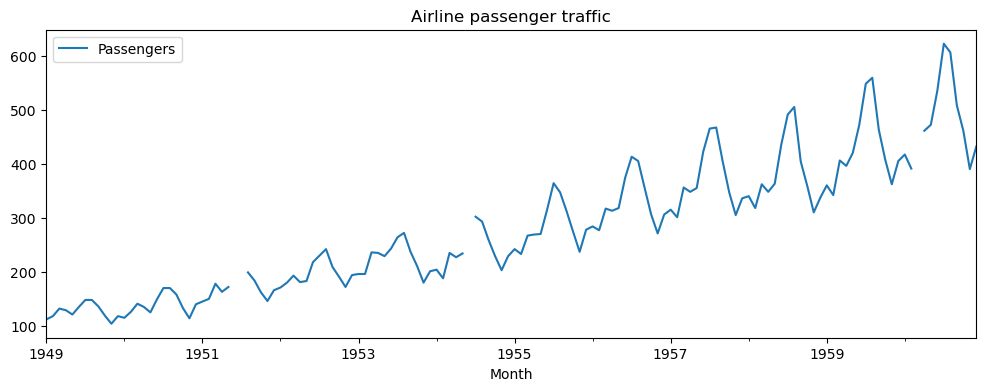

In [3]:
data.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Airline passenger traffic')
plt.show(block=False)

### Missing value treatment

#### Mean imputation

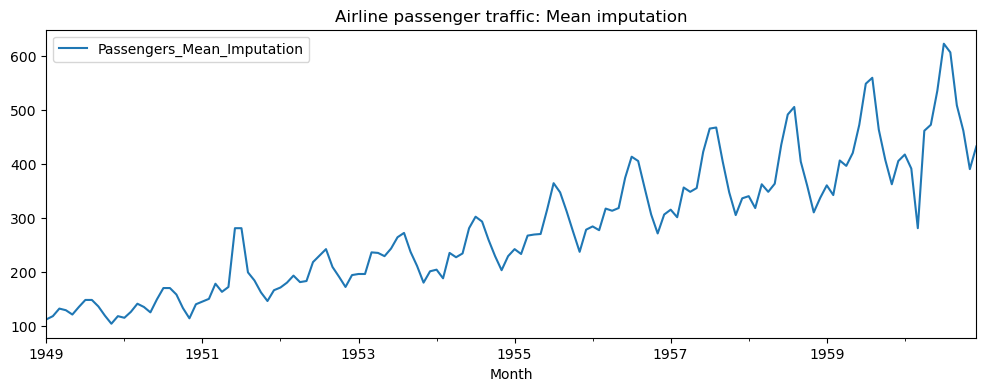

In [4]:
data = data.assign(Passengers_Mean_Imputation=data.Passengers.fillna(data.Passengers.mean()))
data[['Passengers_Mean_Imputation']].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Airline passenger traffic: Mean imputation')
plt.show(block=False)

#### Linear interpolation

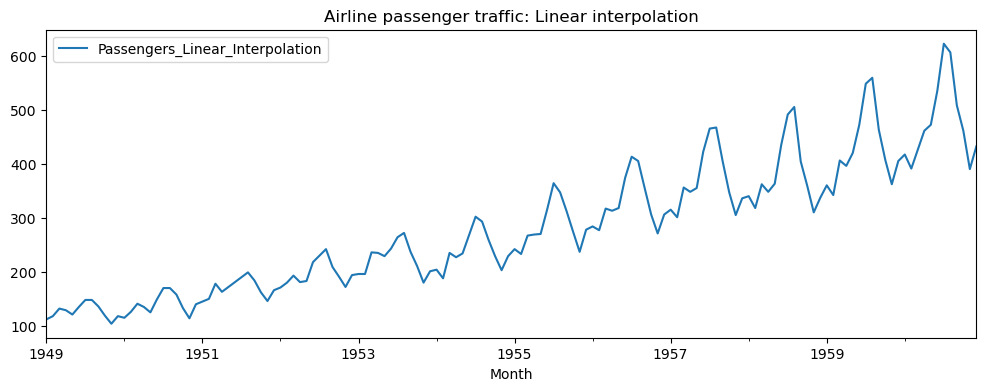

In [5]:
data = data.assign(Passengers_Linear_Interpolation=data.Passengers.interpolate(method='linear'))
data[['Passengers_Linear_Interpolation']].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Airline passenger traffic: Linear interpolation')
plt.show(block=False)

In [6]:
### Use linear interpolation to impute missing values
data['Passengers'] = data['Passengers_Linear_Interpolation']
data.drop(columns=['Passengers_Mean_Imputation','Passengers_Linear_Interpolation'],inplace=True)

### Outlier detection

#### Box plot and interquartile range

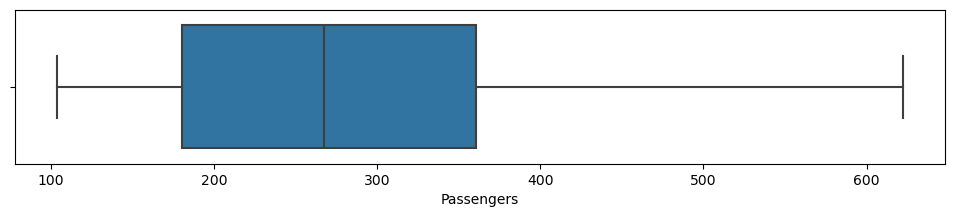

In [7]:
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=data['Passengers'],whis=1.5)

There are not outliers observed using boxplot method

#### Histogram plot

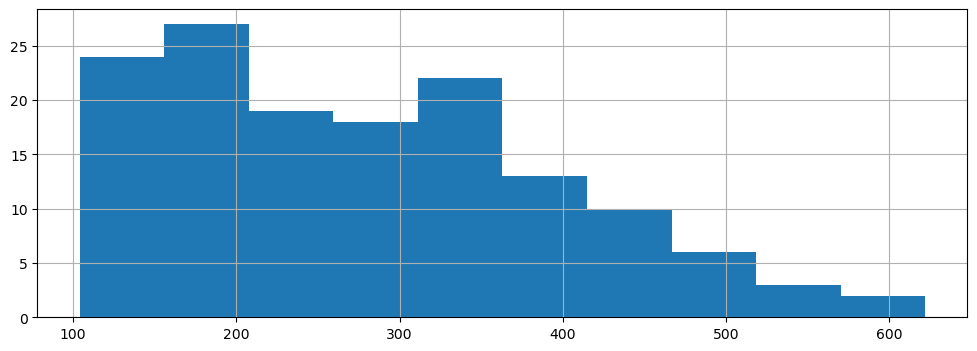

In [8]:
fig = data.Passengers.hist(figsize = (12,4))

There are not outliers observed using histogram method as well

### Time series Decomposition

#### Additive seasonal decomposition

In [9]:
# import some relevant packages
from pylab import rcParams
import statsmodels.api as sm

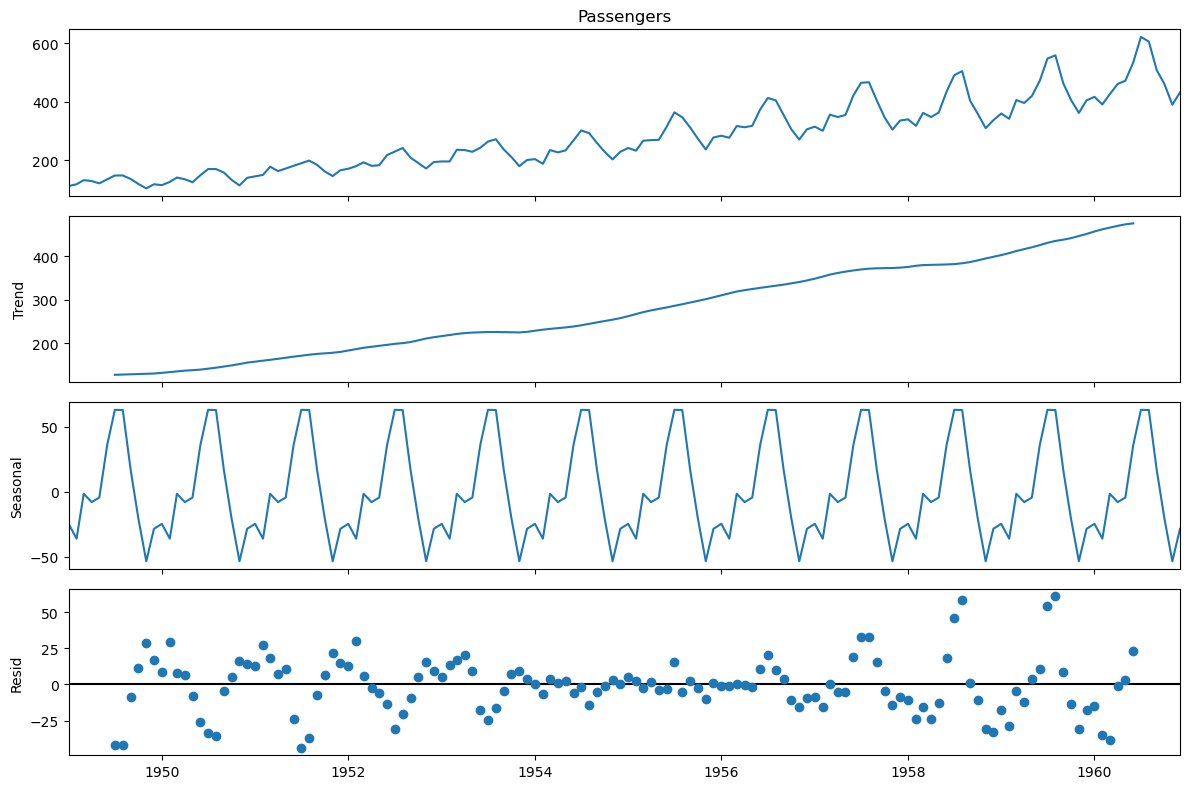

In [10]:
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(data.Passengers, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

#### Multiplicative seasonal decomposition

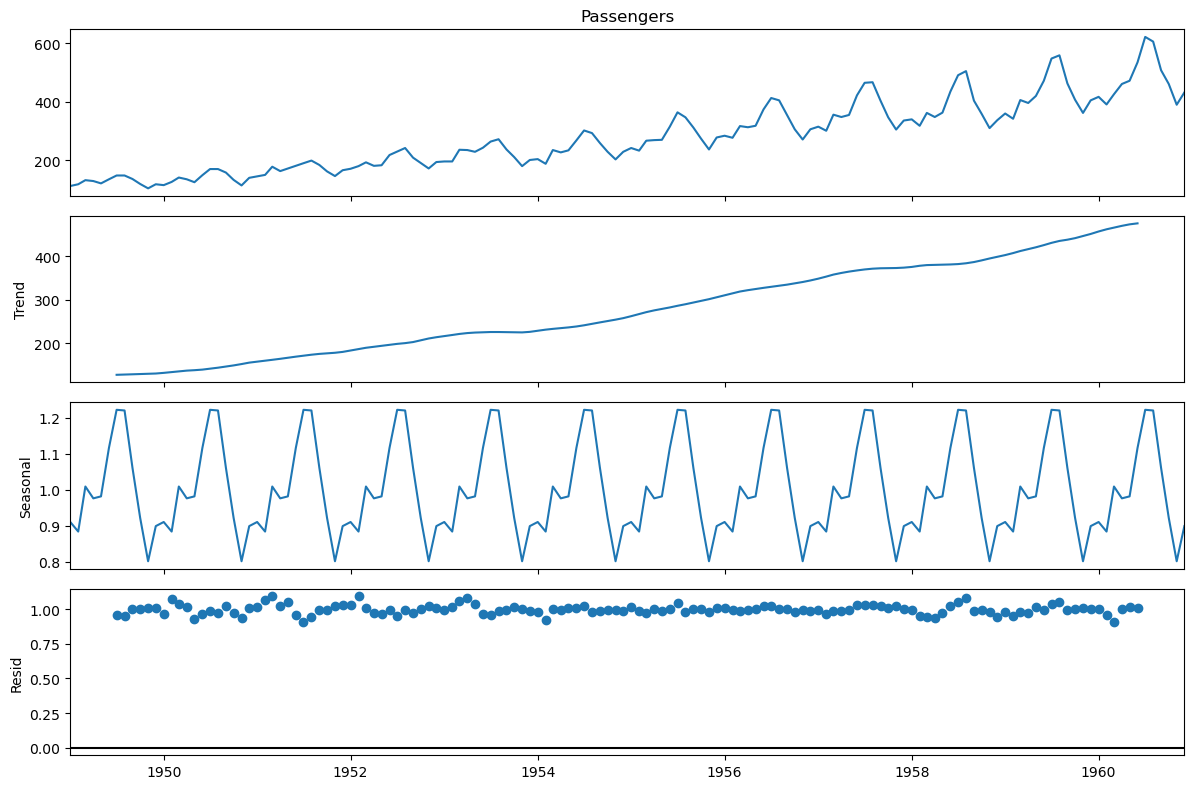

In [11]:
decomposition = sm.tsa.seasonal_decompose(data.Passengers, model='multiplicative') # multiplicative seasonal index
fig = decomposition.plot()
plt.show()

### Build and evaluate time series forecast

#### Split time series data into training and test set

In [12]:
train_len = 120
train = data[0:train_len] # first 120 months as training set
test = data[train_len:] # last 24 months as out-of-time test set

### Simple time series methods

#### Naive method

In [13]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['Passengers'][train_len-1]

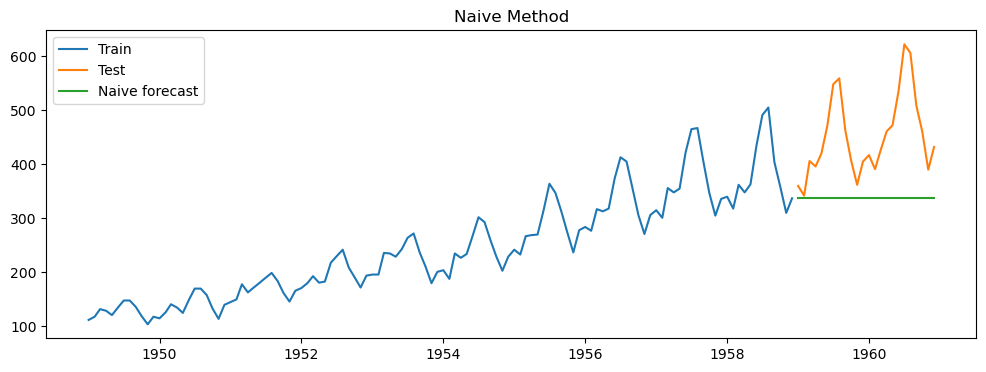

In [14]:
# Plot train, test and forecast
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Naive Method')
plt.show()

### Calculate RMSE and MAPE

In [15]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_naive['naive_forecast'])/test['Passengers'])*100,2)

results = pd.DataFrame({'Method':['Naive method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63


#### Simple average method

In [16]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Passengers'].mean()

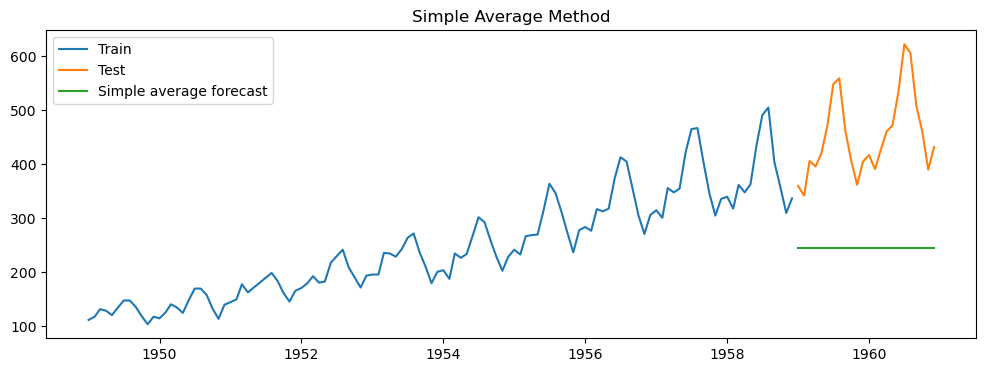

In [17]:
# Plot train, test and forecast
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Simple average forecast')
plt.legend(loc='best')
plt.title('Simple Average Method')
plt.show()

### Calculate RMSE and MAPE

In [18]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_avg['avg_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_avg['avg_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple average method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28


### Simple moving average method

In [19]:
y_hat_sma = data.copy()
ma_window = 12
y_hat_sma['sma_forecast'] = data['Passengers'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

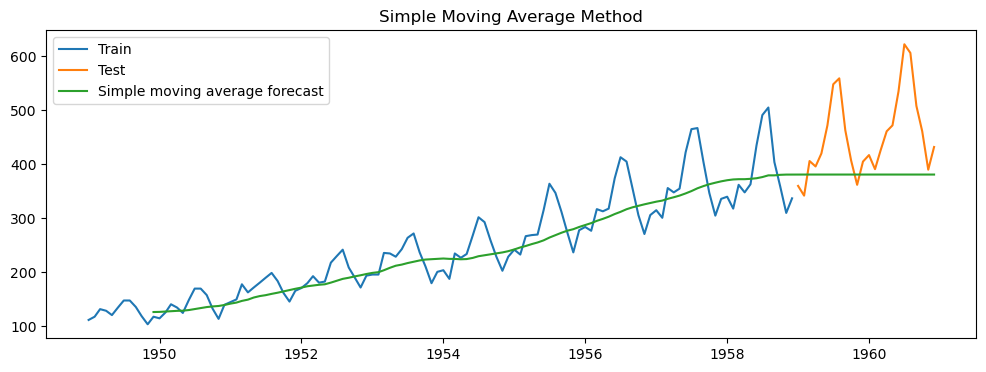

In [20]:
# Plot train, test and forecast
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

### Calculate RMSE and MAPE

In [21]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_sma['sma_forecast'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_sma['sma_forecast'][train_len:])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple moving average forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54


### Exponential smoothing methods

#### Simple exponential smoothing

In [22]:
# import some more relevant packages
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [23]:
model = SimpleExpSmoothing(train['Passengers'])
model_fit = model.fit(smoothing_level=0.2,optimized=False)
model_fit.params
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(24)

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


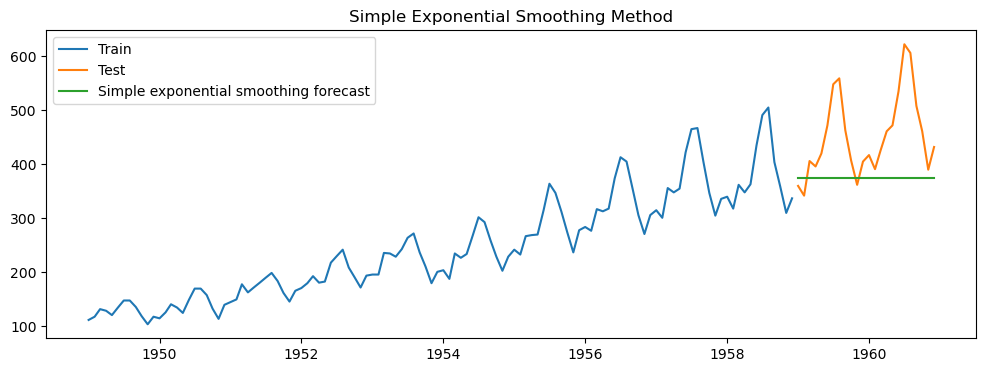

In [24]:
# Plot train, test and forecast
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

### Calculate RMSE and MAPE

In [25]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_ses['ses_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple exponential smoothing forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54
0,Simple exponential smoothing forecast,107.65,16.49


#### Holt's method with trend

In [26]:
# Import some more relevant packages
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [27]:
model = ExponentialSmoothing(np.asarray(train['Passengers']) ,seasonal_periods=12 ,trend='additive', seasonal=None)
model_fit = model.fit(smoothing_level=0.2, smoothing_slope=0.01, optimized=False)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.2, 'smoothing_trend': 0.01, 'smoothing_seasonal': None, 'damping_trend': nan, 'initial_level': 118.46666666666661, 'initial_trend': 2.060606060606076, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


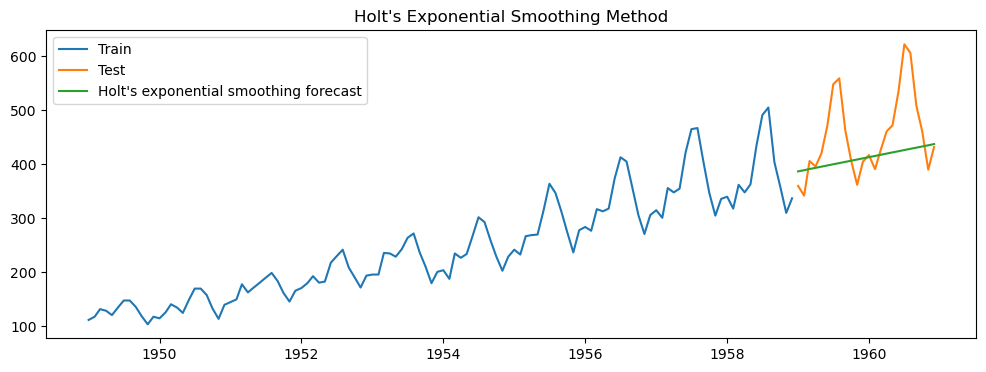

In [28]:
# Plot train, test and forecast
plt.figure(figsize=(12,4))
plt.plot( train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

### Calculate RSME and MAPE

In [29]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_holt['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_holt['holt_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt\'s exponential smoothing method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54
0,Simple exponential smoothing forecast,107.65,16.49
0,Holt's exponential smoothing method,80.91,11.39


### Holt Winters' additive method with trend and seasonality

In [30]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['Passengers']) ,seasonal_periods=12 ,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hw_forecast'] = model_fit.forecast(24)

{'smoothing_level': 0.23610519385983644, 'smoothing_trend': 3.767358813391642e-10, 'smoothing_seasonal': 0.7638948043662962, 'damping_trend': nan, 'initial_level': 119.13929422260277, 'initial_trend': 2.2766929524035415, 'initial_seasons': array([ -9.41601912,  -3.88916719,   8.62665381,   3.53727581,
        -5.16003991,   8.98380437,  21.25011288,  19.33131515,
         5.24403382, -13.60379144, -28.28563077, -12.13517361]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


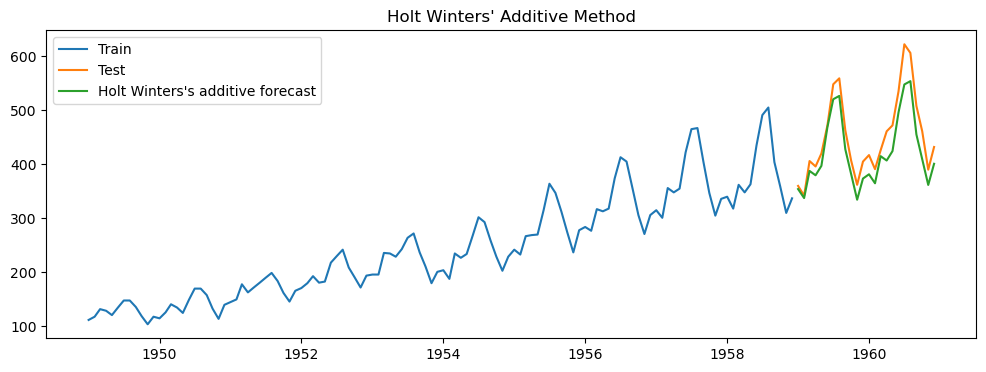

In [31]:
# Plot train, test and forecast
plt.figure(figsize=(12,4))
plt.plot( train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_hwa['hw_forecast'], label='Holt Winters\'s additive forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Additive Method')
plt.show()

### Calculate RMSE and MAPE

In [32]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_hwa['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_hwa['hw_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' additive method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54
0,Simple exponential smoothing forecast,107.65,16.49
0,Holt's exponential smoothing method,80.91,11.39
0,Holt Winters' additive method,35.87,6.72


### Holt Winter's multiplicative method with trend and seasonality

In [33]:
y_hat_hwm = test.copy()
model = ExponentialSmoothing(np.asarray(train['Passengers']) ,seasonal_periods=12 ,trend='add', seasonal='mul')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwm['hw_forecast'] = model_fit.forecast(24)

{'smoothing_level': 0.3655840041217044, 'smoothing_trend': 2.883077823313447e-08, 'smoothing_seasonal': 0.6344159877671911, 'damping_trend': nan, 'initial_level': 98.6773669526238, 'initial_trend': 2.1370584455630506, 'initial_seasons': array([1.11094177, 1.1685548 , 1.2844355 , 1.22107968, 1.12706566,
       1.2325233 , 1.34029533, 1.33120888, 1.21435337, 1.05820299,
       0.94078181, 1.08538936]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


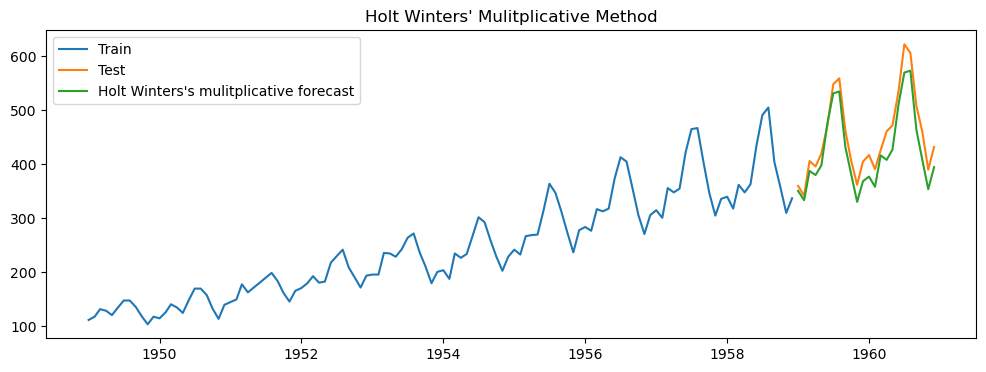

In [34]:
#  Plot train, test and forecast
plt.figure(figsize=(12,4))
plt.plot( train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_hwm['hw_forecast'], label='Holt Winters\'s mulitplicative forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Mulitplicative Method')
plt.show()

### Calculate RMSE and MAPE

In [35]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_hwm['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_hwm['hw_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' multiplicative method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54
0,Simple exponential smoothing forecast,107.65,16.49
0,Holt's exponential smoothing method,80.91,11.39
0,Holt Winters' additive method,35.87,6.72
0,Holt Winters' multiplicative method,32.46,6.45


Here we can Holt's Winter considering Seasonality and trend both forecast more accurately out of all the methods we tried

## Auto Regressive methods

### Stationarity vs non-stationary time series

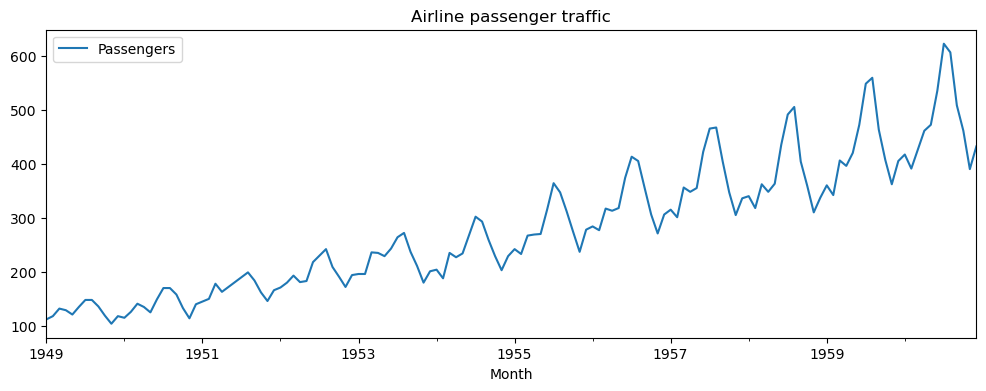

In [36]:
data['Passengers'].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Airline passenger traffic')
plt.show(block=False)

### Augmented Dickey-Fuller (ADF) test

In [37]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data['Passengers'])

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: 0.894609
Critical Values @ 0.05: -2.88
p-value: 0.993020


As we can observe p-value is greater than 0.05 so we can not reject the null hypothesis(which is Time Series is not stationary for ADF test). We can conclude time series is not stationary as per ADF test

### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [38]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(data['Passengers'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 1.651190
Critical Values @ 0.05: 0.46
p-value: 0.010000


/var/folders/gv/r771h3zn7cz5dqxf_d4wg09c0000gn/T/ipykernel_23947/3602609379.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(data['Passengers'])


As we can observe p-value is less than 0.05 so we can reject the null hypothesis(which is Time Series is stationary for KPSS test). We can conclude time series is not stationary as per KPSS test

### Box Cox transformation to make variance constant

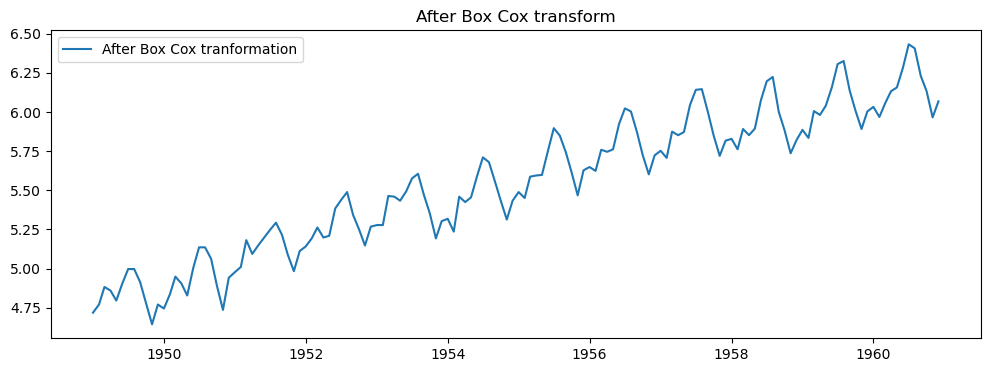

In [39]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data['Passengers'], lmbda=0), index = data.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

### Differencing to remove trend

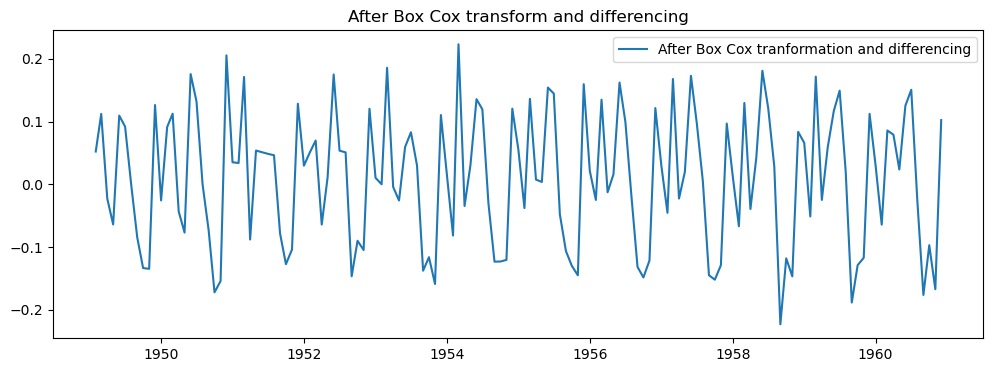

In [40]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), data.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [41]:
data_boxcox_diff.dropna(inplace=True)

In [42]:
data_boxcox_diff.tail()

Month
1960-08-01   -0.026060
1960-09-01   -0.176399
1960-10-01   -0.097083
1960-11-01   -0.167251
1960-12-01    0.102279
dtype: float64

### Augmented Dickey-Fuller (ADF) test

In [43]:
adf_test = adfuller(data_boxcox_diff)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -3.290114
Critical Values @ 0.05: -2.88
p-value: 0.015326


As we can observe now p-value is less than 0.05 so we can reject the null hypothesis(which is Time Series is not stationary for ADF test). We can conclude time series is stationary as per ADF test

### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [44]:
kpss_test = kpss(data_boxcox_diff)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.038341
Critical Values @ 0.05: 0.46
p-value: 0.100000


/var/folders/gv/r771h3zn7cz5dqxf_d4wg09c0000gn/T/ipykernel_23947/3639712988.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(data_boxcox_diff)


As we can observe now p-value is greater than 0.05 so we can reject the null hypothesis(which is Time Series is stationary for KPSS test). We can conclude time series is stationary as per KPSS test

### Autocorrelation function (ACF)

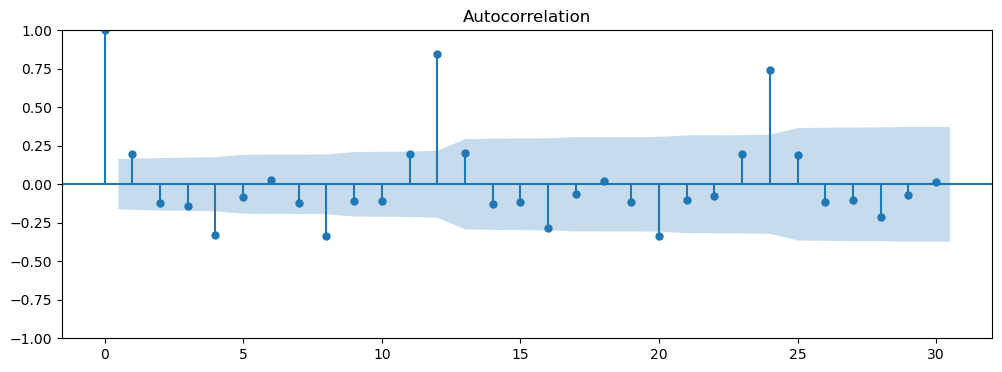

In [45]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12,4))
plot_acf(data_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

### Partial autocorrelation function (PACF)

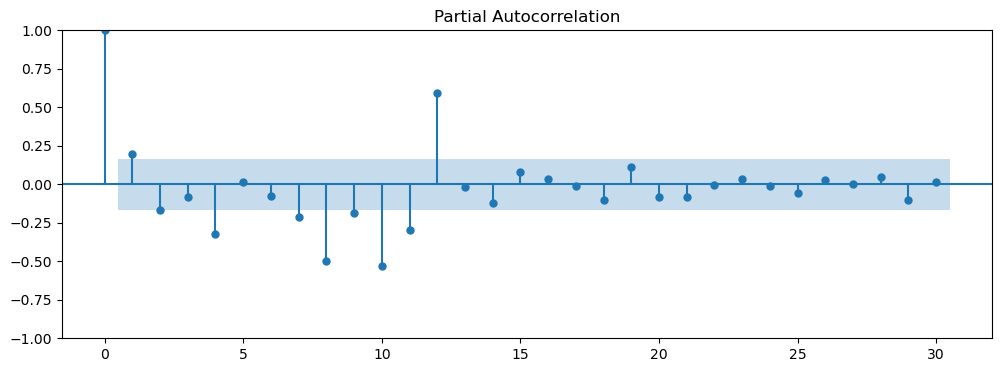

In [46]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12,4))
plot_pacf(data_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

#### Split the data into training and test data sets

In [47]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

In [48]:
train_data_boxcox_diff.head()

Month
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
1949-06-01    0.109484
dtype: float64

### Auto regression method (AR)

In [49]:
# Import relevant packages
from statsmodels.tsa.arima.model import ARIMA

In [50]:
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 0)) 
model_fit = model.fit()
print(model_fit.params)

const     0.009473
ar.L1     0.183106
sigma2    0.010680
dtype: float64


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


#### Recover original time series

In [51]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

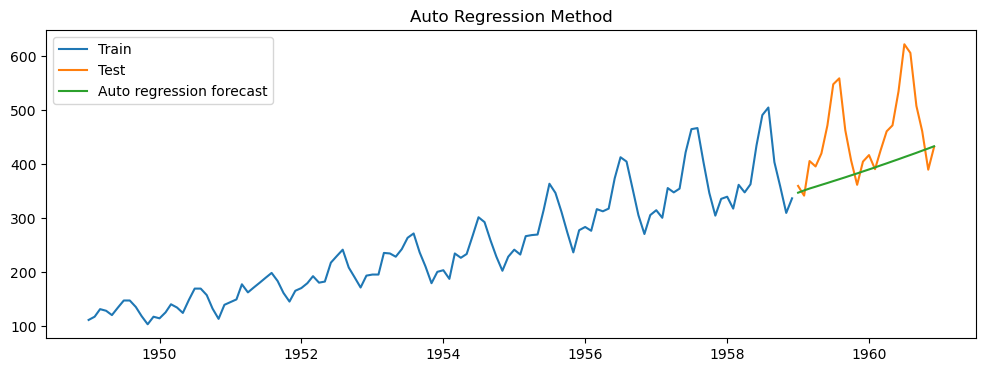

In [52]:
# Plot train, test and forecast
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto regression forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

### Calculate RMSE and MAPE

In [53]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_ar['ar_forecast'][test.index.min():])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive (AR) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54
0,Simple exponential smoothing forecast,107.65,16.49
0,Holt's exponential smoothing method,80.91,11.39
0,Holt Winters' additive method,35.87,6.72
0,Holt Winters' multiplicative method,32.46,6.45
0,Autoregressive (AR) method,93.49,13.78
